# USS assets 
## historic growth 1992-2023 
## forecast growth from discount rates 2011, 14, 17, 18, 20, 21, 23

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as sta
import csv

In [2]:
import uss_pensions as up

ONS data loading:
Annual CPI change, monthly, as array             cpi_annual_monthly_ons, last entry [2.02404167e+03 4.00000000e-02]
Annual CPI change, annually, as array            cpi_annual_annually_ons
Annual CPI change, annually Jan-Jan, as array    cpi_annual_jan_jan_ons
Annual CPI index (2015=1.00), monthly, as array  cpi_index_monthly_ons, last entry [2.02404167e+03 1.31500000e+00]

USS historic assets and investment growth data loading:
Assets (nominal, B GBP) from annual report       assets_nom
Investment returns (nominal basis)               inv_ret_nom
Estimating USS assets from investment returns, normalised to nominal assets in year 2023.25:
Stored in array:                                 cum_inv_ret_nom
USS discount rates data loading:
Prudent discount rates as dictionary             disc_prud_cpi_dict
dict_keys(['2011', '2014', '2017a', '2017b', '2018', '2019', '2020a', '2020b', '2021a', '2021b', '2022a', '2022b', '2022c', '2022d', '2022e', '2022f', '2023'])
Best esti

In [3]:
print("CPI2015.5 index at last assets report date", up.get_cpi_index_ons(up.assets_nom[-1,0], 2015.5)[0,1])
print("CPI2015.5 index applied to assets         ", (up.assets_nom[-1,:]/up.get_cpi_adjusted(up.assets_nom, 2015.5)[-1,:])[1])

CPI2015.5 index at last assets report date 1.2951837699739726
CPI2015.5 index applied to assets          1.2951837699739726


In [4]:
# To choose whether to save plots and data, set the following to True or False
save_plots = False
save_data = False
plots_path = '../graphs/'
outputs_path = '../data/code_outputs/'

In [5]:
# Choose base year for CPI
up.BASE_YEAR = 2023.25
up.assets_reported_cpi, up.assets_inv_ret_cpi = up.assets_nominal_to_cpi(up.BASE_YEAR)


Converting reported assets and estimated assets to CPI basis, base year 2023.25:
Reported assets CPI stored in array:            assets_reported_cpi
Estimated assets CPI stored in array:            assets_inv_ret_cpi
*** Note 1: assets are estimated using investment returns, with reported assets at 2023.25 as the basis
*** Note 2: they are estimated at end March by geometric interpolation of end Dec values.



## USS asset projections with "prudent" discount rates

In [6]:
# Assemble dictionary of projected assets estimated from USS prudent discount rates

proj_assets_prud_cpi = {}
end_year = 2068

# skip_list = ['2017a', '2019', '2020b', '2021b', '2022a', '2022b', '2022c', '2022d', '2022e', '2022f']
include_list = ['2011', '2014', '2017b', '2018', '2020a', '2021a', '2023']

for val in up.valuation_list:
    if val in include_list:
        year = int(val[:4])
        y = np.arange(year + 1, end_year)
        assets_start = up.get_assets_cpi_reported(year+0.25, up.BASE_YEAR)[0,1]
        if val == '2022c' or val == '2022d':
            assets_start = up.get_assets_cpi_reported(year+0.5, up.BASE_YEAR)[0,1]
        if val == '2022e' or val == '2022f':
            assets_start = up.get_assets_cpi_reported(year+0.75, up.BASE_YEAR)[0,1]
        assets = np.stack((y, np.ones_like(y)*assets_start), axis=1)
        disc_rates = up.get_cum_disc_uss_cpi(y, val)
        assets[:,1] /= disc_rates[:,1]
        proj_assets_prud_cpi[val] = assets
        print(f'Assets projected with "prudent" discount rate for valuation {val:}')


Assets projected with "prudent" discount rate for valuation 2011
Assets projected with "prudent" discount rate for valuation 2014
Assets projected with "prudent" discount rate for valuation 2017b
Assets projected with "prudent" discount rate for valuation 2018
Assets projected with "prudent" discount rate for valuation 2020a
Assets projected with "prudent" discount rate for valuation 2021a
Assets projected with "prudent" discount rate for valuation 2023


Let's calculate what this "prudent" estimate of growth gives for the annualised growth rate over the next 30 years.

In [7]:
ann_30_prud_grow_rate = {}

for val in up.disc_prud_cpi_dict:
    if val in include_list:
        ann_30_prud_grow_rate[val] = up.get_annualised_growth_rate(up.disc_prud_cpi_dict[val])
        print('USS "prudent" ' + f'{val:5s}' + " 30-year annualised growth rate (CPI basis): {:.2f} %".format(100*ann_30_prud_grow_rate[val]))

USS "prudent" 2011  30-year annualised growth rate (CPI basis): 3.50 %
USS "prudent" 2014  30-year annualised growth rate (CPI basis): 2.21 %
USS "prudent" 2017b 30-year annualised growth rate (CPI basis): 0.97 %
USS "prudent" 2018  30-year annualised growth rate (CPI basis): 1.11 %
USS "prudent" 2020a 30-year annualised growth rate (CPI basis): 0.20 %
USS "prudent" 2021a 30-year annualised growth rate (CPI basis): -0.06 %
USS "prudent" 2023  30-year annualised growth rate (CPI basis): 2.20 %


Saved figure to ../graphs/uss_assets_and_prudent_forecasts_2023MAR_cpi_2023MAR.pdf
Saved figure to ../graphs/uss_assets_and_prudent_forecasts_2023MAR_cpi_2023MAR.png


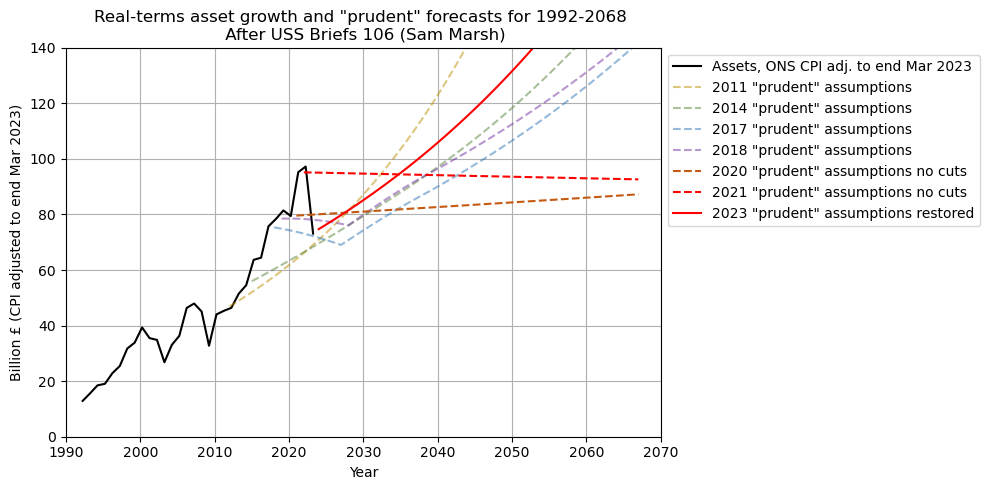

In [13]:
plt.figure(figsize=(10,5))

latest_year, latest_month = up.get_year_month_string(up.assets_reported_cpi[-1,0])
cpi_year, cpi_month = up.get_year_month_string(up.BASE_YEAR)

plt.plot(up.assets_reported_cpi[:,0], up.assets_reported_cpi[:,1], 
         color='k', 
         label='Assets, ONS CPI adj. to end {:} {:}'.format(cpi_month.lower().capitalize(), cpi_year))

# Computation from returns can be unreliable
#
# plt.plot(up.assets_inv_ret_cpi[:,0], up.assets_inv_ret_cpi[:,1], 
#          color='k', 
#          label='From returns, ONS CPI adj. to {}'.format(up.BASE_YEAR))

# remember, include_list = ['2011', '2014', '2017b', '2018', '2020a', '2021a', '2023']
yr_list = [inc[0:4] for inc in include_list]

# Matches original Excel colours
rgb_list = [(191,144,0), 
            (84,130,53), 
            (46,117,182), 
            (112,48,160), 
            (197,90,17), 
            (255,0,0), 
            (255,0,0)]
col_list = [(r/256,g/256,b/256) for r,g,b in rgb_list]
col_dict = dict(zip(yr_list, col_list))
alpha_list = [0.5]*(len(proj_assets_prud_cpi)-3) + [1]*3
ls_list = ['--']*len(proj_assets_prud_cpi)
ls_list[-1] = '-'

lab_list = ['{:} "{:}" assumptions']*len(proj_assets_prud_cpi)
lab_list[-3] += ' no cuts'
lab_list[-2] += ' no cuts'
lab_list[-1] += ' restored'

dp = {}
for val, al, ls, lab in zip(proj_assets_prud_cpi, alpha_list, ls_list, lab_list):
    col = col_dict[val[0:4]]
    dp[val] = {"color" : col, "alpha" : al, "ls" : ls, "label" : lab}

for val in proj_assets_prud_cpi:
    label = dp[val]["label"].format(val[0:4], 'prudent')
    if val == '2022a' or val == '2022b':
        label=dp[val]["label"].format(val[0:4] + ' Mar', 'prudent')
    if val == '2022c' or val == '2022d':
        label=dp[val]["label"].format(val[0:4] + ' Jun', 'prudent')
    if val == '2022e' or val == '2022f':
        label=dp[val]["label"].format(val[0:4] + ' Sep', 'prudent')
    plt.plot(proj_assets_prud_cpi[val][:,0], proj_assets_prud_cpi[val][:,1], 
             color=dp[val]["color"], 
             ls=dp[val]["ls"], 
             alpha=dp[val]["alpha"], 
             label=label)

plt.xlim(1990,2070)
plt.ylim(0,140)

latest_year, latest_month = up.get_year_month_string(up.assets_reported_cpi[-1,0])
cpi_year, cpi_month = up.get_year_month_string(up.BASE_YEAR)

plt.title('Real-terms asset growth and "prudent" forecasts for 1992-2068 \n After USS Briefs 106 (Sam Marsh)')
plt.xlabel('Year')
plt.ylabel('Billion £ (CPI adjusted to end {:} {:})'.format(cpi_month.lower().capitalize(), cpi_year))


plt.grid()
plt.legend(bbox_to_anchor=(1.0, 0.0, .1, 1))

plt.tight_layout()
if save_plots:
    filestem = "uss_assets_and_prudent_forecasts_{}_cpi_{}".format(latest_year + latest_month, 
                                                                   cpi_year + cpi_month)
    plt.savefig(plots_path + filestem + '.pdf')
    print('Saved figure to', plots_path + filestem + '.pdf')
    plt.savefig(plots_path + filestem + '.png')
    print('Saved figure to', plots_path + filestem + '.png')
    

In [10]:
if save_data:
    latest_year, latest_month = up.get_year_month_string(up.assets_reported_cpi[-1,0])
    cpi_year, cpi_month = up.get_year_month_string(up.BASE_YEAR)
    fn_inv_ret_cpi = outputs_path + '1992_{:}_assets_from_investment_returns_cpi{:}.csv'.format(latest_year + latest_month,
                                                                                                cpi_year + cpi_month)
    fn_reported_cpi = outputs_path + '1992_{:}_assets_reported_cpi{:}.csv'.format(latest_year + latest_month,
                                                                                                cpi_year + cpi_month)

    field = 'Assets value (B GBP, CPI {})'.format(up.BASE_YEAR)
    
    up.write_csv(fn_inv_ret_cpi, field, up.assets_inv_ret_cpi )
    up.write_csv(fn_reported_cpi, field, up.assets_reported_cpi )



Array of Assets value (B GBP, CPI 2023.25) written to file ../data/code_outputs/1992_2023MAR_assets_from_investment_returns_cpi2023MAR.csv
Array of Assets value (B GBP, CPI 2023.25) written to file ../data/code_outputs/1992_2023MAR_assets_reported_cpi2023MAR.csv
